In [1]:
import sys
sys.path.append("/home/huaqingj/MyResearch/TVDN")

In [2]:
from pyTVDN import TVDNDetect, TVDNRankTuning
from pathlib import Path
from scipy.io import loadmat
from scipy.signal import detrend
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyTVDN.tmpUtils import *
from scipy.signal import lfilter, firls, decimate
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False
plt.rcParams["axes.edgecolor"] = "0.3"
#plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams['axes.labelcolor']='black'

In [30]:
from pprint import pprint
import pickle
from easydict import EasyDict as edict
import warnings
from pyTVDN.TVDNutils import *
from pyTVDN.utils import in_notebook
from tqdm import tqdm

class TVDNDetect1(TVDNDetect):
    def SmoothEst(self):
        if self.nYmat is None:
            self._Preprocess()
        d, n = self.nYmat.shape
        acTime = n / self.paras.freq
        self.ptime = np.linspace(0, acTime, n)
        self.time = np.linspace(0, self.paras.T, n)
        divNum = 100
        if self.smoothType == "bspline":
            self.dXmat = np.zeros((d, n))
            self.Xmat = np.zeros((d, n))
            if n%divNum == 0:
                numLoop = int(n/divNum)
            else:
                numLoop = int(n/divNum) + 1
            for i in range(numLoop):
                if (i+1)*divNum <= n:
                    low = i*divNum
                    up = (i+1)*divNum
                else:
                    low = i*divNum
                    up = n
                self.dXmat[:, low:up], self.Xmat[:, low:up] = GetBsplineEst(self.nYmat[:, low:up], self.time[low:up], 
                                                                            lamb=self.paras.lamb)
        elif self.smoothType == "fourier":
            self.dXmat, self.Xmat = GetFourierEst(self.nYmat, self.time, nbasis=self.paras.nbasis)
            

In [4]:
resDir = Path("../results")
dataDir = Path("../data/MEG-eye-unfiltering-0203")

In [5]:
datFil = list(dataDir.glob("*02*min.mat"))[0]
print(datFil)
gtF = list(dataDir.glob("*02_st.txt"))[0]
gtSt02 = time2pts(txt2Time(gtF), timeLims.st02)

../data/MEG-eye-unfiltering-0203/lcmv_result_R2868E_02-st_wo_filtering_min.mat


In [6]:
MEG = loadmat(datFil)
data = MEG["DK_timecourse"]

The time course is 60 seconds, so the frequency is 1200 Hz

###  Data preprocessing

In [7]:
q = 10
# originally, it is 'iir', but I dont know why it gives NAN output
# Anyway, change it to 'fir' does not affect the result a lot
# under scipy 1.3.0, works well, 
# but under scipy 1.6.2, we should use "fir" other than "iir", otherwise the decimate steps output non
dataN = decimate(data, q=q)
dataN = detrend(dataN)

## Detection on data with screening and no HPF

In [8]:
paras = edict()
paras.Lmin = 200
paras.wh = 10
paras.MaxM = 20
paras.fct = 0.5
paras.r = 0.7
paras.freq = 120
paras.lamb = 1e-4
paras.T = 2
paras.is_detrend = False
paras.decimateRate = None
paras.kappa = 1
paras.downRate = 20

In [9]:
detRaw = TVDNDetect1(Ymat=dataN, dataType="MEG", 
                     saveDir=None, #"MEGst02", 
                     fName="MEG1",
                     showProgress=True, 
                     MaxM=paras.MaxM,
                     Lmin=paras.Lmin, 
                     lamb=paras.lamb, 
                     kappa=paras.kappa, 
                     freq=paras.freq,
                     r=paras.r,
                     T=paras.T,
                     is_detrend=paras.is_detrend,
                     decimateRate=paras.decimateRate, 
                     downRate=paras.downRate)

The parameters for detection are:
{'Lmin': 200,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 20,
 'fName': 'MEG1',
 'fct': 0.5,
 'freq': 120,
 'is_detrend': False,
 'kappa': 1,
 'lamb': 0.0001,
 'nbasis': 10,
 'r': 0.7}


In [10]:
detRaw.Screening(wh=paras.wh)
detRaw()

Dynamic Programming: 100%|██████████| 358/358 [00:40<00:00,  8.92it/s]


In [11]:
kappas = np.arange(1, 4, 0.001)
detRaw.TuningKappa(kappas)

Kappa Tuning: 100%|██████████| 21/21 [00:11<00:00,  2.54it/s]


+-------------+---------------------------------------+--------------------+------+
| Num of CPTs |             Estiamted CPTs            |        MSE         | Rank |
+-------------+---------------------------------------+--------------------+------+
|      6      | [ 337. 1600. 3032. 4366. 5556. 7000.] | 4.5132746925310485 |  5   |
+-------------+---------------------------------------+--------------------+------+


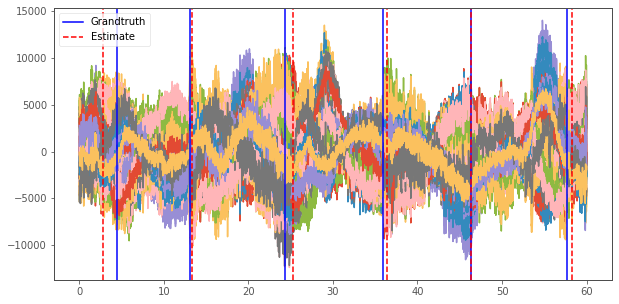

In [12]:
detRaw.UpdateEcpts(6)
print(detRaw)
detRaw.PlotEcpts(GT=gtSt02.cpts)

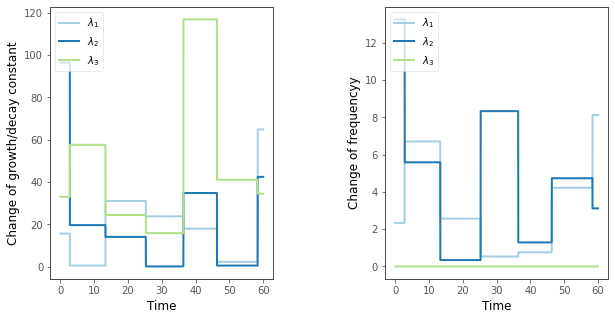

In [13]:
detRaw.PlotEigenCurve()

### Detection without screening

In [14]:
detRawNo = TVDNDetect1(Ymat=dataN, dataType="MEG", 
                     saveDir="../results/MEGeye-st02-ada",
                     fName="MEGEYE-st02",
                     showProgress=True, 
                     MaxM=paras.MaxM,
                     Lmin=paras.Lmin, 
                     lamb=paras.lamb, 
                     kappa=paras.kappa, 
                     freq=paras.freq,
                     r=paras.r,
                     T=paras.T,
                     is_detrend=paras.is_detrend,
                     decimateRate=paras.decimateRate, 
                     downRate=paras.downRate)

The parameters for detection are:
{'Lmin': 200,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 20,
 'fName': 'MEGEYE-st02',
 'fct': 0.5,
 'freq': 120,
 'is_detrend': False,
 'kappa': 1,
 'lamb': 0.0001,
 'nbasis': 10,
 'r': 0.7}


In [15]:
detRawNo()

/home/huaqingj/MyResearch/TVDN/pyTVDN/TVDNclass.py:290: UserWarning: As loading the saved results, kappa will be ignored
  warnings.warn("As loading the saved results, kappa will be ignored", UserWarning)


In [16]:
kappas = np.arange(1, 4, 0.001)
detRawNo.TuningKappa(kappas)

+-------------+---------------------------------------+-------------------+------+
| Num of CPTs |             Estiamted CPTs            |        MSE        | Rank |
+-------------+---------------------------------------+-------------------+------+
|      6      | [ 339. 1600. 3030. 4368. 5555. 7000.] | 4.614666029953395 |  5   |
+-------------+---------------------------------------+-------------------+------+


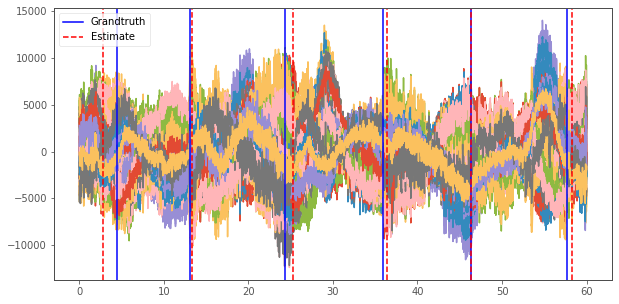

In [17]:
detRawNo.UpdateEcpts(6)
print(detRawNo)
detRawNo.PlotEcpts(GT=gtSt02.cpts)

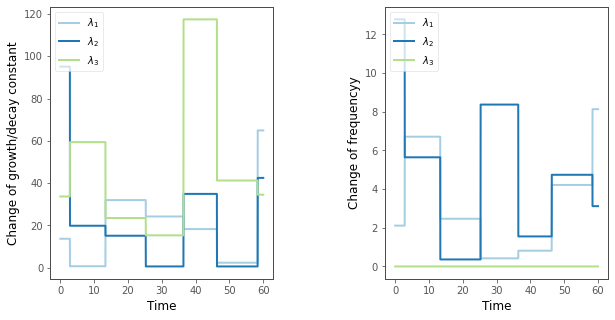

In [18]:
detRawNo.PlotEigenCurve()

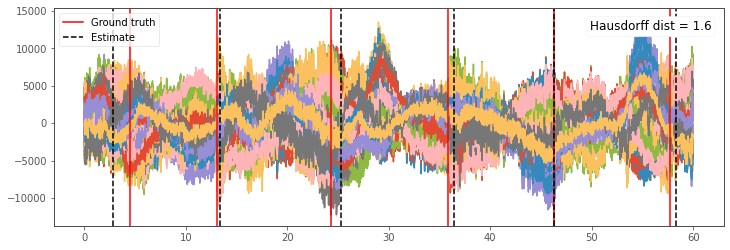

In [19]:
props = dict(boxstyle='round', facecolor='white', alpha=1)

d, n = detRawNo.nYmat.shape
acTime = n / detRawNo.paras.freq
ajfct = n/acTime
plt.figure(figsize=[12, 4])
for i in range(d):
    plt.plot(detRawNo.ptime, detRawNo.nYmat[i, :], "-")

ecpts = detRawNo.ecpts
chist = hdist(ecpts/ajfct, gtSt02.ts)
ax = plt.gca()
ax.text(0.80, 0.90, f'Hausdorff dist = {np.round(chist, 1)}', transform=ax.transAxes, fontsize=12, bbox=props)
for j, cpt in enumerate(gtSt02.cpts):
    if j == 0:
        plt.axvline(cpt/ajfct, color="red", linestyle="-", label="Ground truth")
    else:
        plt.axvline(cpt/ajfct, color="red", linestyle="-")
for j, ecpt in enumerate(ecpts):
    if j == 0:
        plt.axvline(ecpt/ajfct, color="black", linestyle="--", label="Estimate")
    else:
        plt.axvline(ecpt/ajfct, color="black", linestyle="--")

plt.legend(loc="upper left")
#plt.savefig("../plots/MEG-EYE-02-TVDN-ecpts.jpg", bbox_inches='tight')
plt.show() 

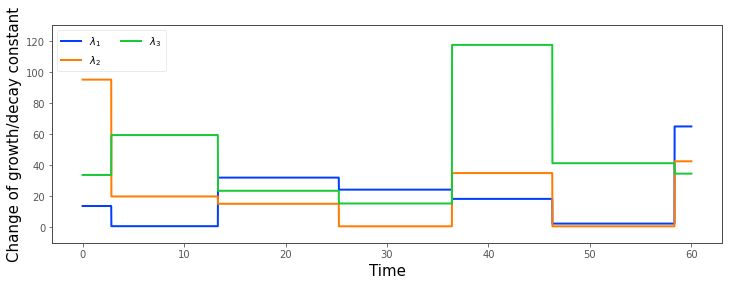

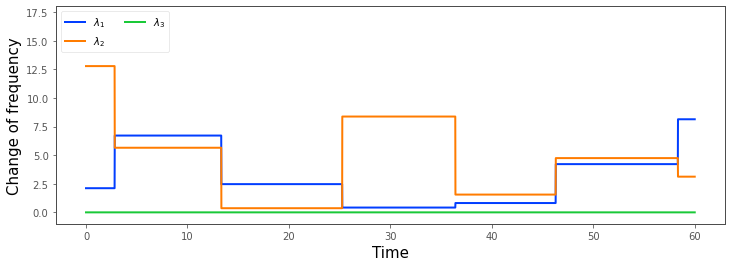

In [20]:
freq = detRawNo.paras.freq
numChgCur = len(detRawNo.ecpts)
LamMs = detRawNo.RecResCur.LamMs
rAct, n = LamMs.shape
pltIdxs = np.arange(1, rAct)[np.diff(np.abs(LamMs), axis=0).astype(np.bool).all(axis=1)] 
pltIdxs = np.concatenate([[0], pltIdxs])
acTime = n / detRawNo.paras.freq
ReLamMs = freq*LamMs.real/(acTime/detRawNo.paras.T)
ImLamMs = freq*LamMs.imag/((2*np.pi)*(acTime/detRawNo.paras.T))
cols = sns.color_palette("bright", len(pltIdxs))

plt.figure(figsize=[12,4])
for i0, i in enumerate(pltIdxs):
    labs = f"$\\lambda_{i0+1}$"
    plt.plot(detRawNo.ptime, np.abs(ReLamMs[i, :]), label=labs, 
             color=cols[i0], linewidth=2)
plt.ylabel("Change of growth/decay constant", fontsize=15)
plt.xlabel("Time", fontsize=15)
plt.ylim([-10, 130])
_ = plt.legend(loc="upper left", ncol=2)
plt.savefig("../plots/MEG-EYE-02-eigReal.jpg", bbox_inches='tight')
plt.show()

plt.figure(figsize=[12,4])
for i0, i in enumerate(pltIdxs):
    labs = f"$\\lambda_{i0+1}$"
    plt.plot(detRawNo.ptime, np.abs(ImLamMs[i, :]), label=labs, 
             color=cols[i0], linewidth=2)
plt.ylabel("Change of frequency", fontsize=15)
plt.ylim([-1,18])
plt.xlabel("Time", fontsize=15)
_ = plt.legend(loc="upper left", ncol=2)
plt.savefig("../plots/MEG-EYE-02-eigImag.jpg", bbox_inches='tight')
plt.show() 

### Test under H0: no changes 


In [21]:
def trainIdxFn(ecpts, n):
    """
    return the indices of training dataset, idx from 0
    """
    ecptsfull = np.concatenate(([0], ecpts, [n]))
    lenSegs = np.diff(ecptsfull)
    kpLenSegs = np.array(lenSegs/2, dtype=int)
    trainIdx = np.concatenate([ecptsfull[i] + np.array(list(range(1, kpLenSegs[i]+1))) for i in range(len(kpLenSegs))])
    return trainIdx - 1

In [24]:
def ReconXmatSWHalfH0(ecpts, ndXmat, nXmat, kpidxs, eigVecs, Ymat, tStep, r, is_full=False):
    """
    Under the null: no change point to reconstruct the seqs
    Input: 
        ecpts: Estimated change points, 
        ndXmat: a rAct x n matrix
        nXmat: a rAct x n matrix
        kpidxs: The intermedian output when calculating ndXmat, nXmat
        eigVecs: The matrix of eigen vectors of A matrix, d x d
        Ymat: The matrix to construct, d x n 
        tStep: The time step
        r: The rank setted beforehand, in most cases, r=rAct. If we have non-complex singular values, r < rAct
        if_full: Where outputing full info or not

    Return:
        Estimated Xmat, d x n
    """
    #print(f"The class calls the new reconstruction function, ReconXmatNew")
    rAct, n = ndXmat.shape
    d, _ = Ymat.shape
    trainIdxs = trainIdxFn(ecpts, n)
    ecptsfull = np.concatenate(([0], ecpts, [n])) - 1
    ecptsfull = ecptsfull.astype(int)
    numchgfull = len(ecptsfull)

    ResegS = np.zeros((numchgfull-1, r), dtype=np.complex)
    for  itr in range(numchgfull-1):
        lower = ecptsfull[itr] + 1
        upper = ecptsfull[itr+1] + 1
        ncol = upper - lower
        hncol = int(ncol/2)
        curIdxs = np.sort(np.random.choice(trainIdxs, size=hncol, replace=0))
        curIdxs = np.array(curIdxs, dtype=int)
        lams = np.zeros(r, dtype=np.complex) + np.inf
        for j in range(int(rAct/2)):
            tY = ndXmat[(2*j):(2*j+2), curIdxs]
            tX = nXmat[(2*j):(2*j+2), curIdxs]
            corY = tY.dot(tX.T)
            corX = np.trace(tX.dot(tX.T))
            a = np.trace(corY)/corX
            b = (corY[1, 0] - corY[0, 1])/corX
            lams[kpidxs[j]] = a + b*1j
        tmpIdx = np.where(lams==np.inf)[0]
        lams[tmpIdx] = np.conjugate(lams[tmpIdx-1])
        ResegS[itr, :] = lams
    
    LamMs = np.zeros((r, n), dtype=np.complex)
    LamMs[:, 0] = ResegS[0, :]
    for itr in range(1, numchgfull):
        lower = ecptsfull[itr-1] + 1
        upper = ecptsfull[itr] + 1
        LamMs[:, lower:upper] = ResegS[itr-1, ].reshape(-1, 1)
    
    ecptsf = np.concatenate([[0], ecpts, [n]])
    fixIdxs = []
    for i, j in zip(ecptsf[:-1], ecptsf[1:]):
        num = int((j-i)/2)
        fixIdxs += list(range(int(i), int(i)+num))
    EstXmat = np.zeros((d, n), dtype=np.complex)
    EstXmat[:, 0] = Ymat[:, 0]
    invEigVecsr = inv(eigVecs)[:r, :]
    eigVecsr = eigVecs[:, :r]
    for i in range(1, n):
        if i in fixIdxs:
            EstXmat[:, i] = Ymat[:, i]
        else:
            mTerm = np.diag(LamMs[:, i])
            rTerm = invEigVecsr.dot(EstXmat[:, i-1])
            EstXmat[:, i] = eigVecsr.dot(mTerm).dot(rTerm) * tStep + EstXmat[:,i-1]
        
    if is_full:
        ReDict = edict()
        ReDict.EstXmatReal = detrend(EstXmat.real)
        ReDict.EstXmatRealOrg = EstXmat.real
        ReDict.EstXmatImag = EstXmat.imag
        ReDict.LamMs = LamMs
        return ReDict
    else:
        return detrend(EstXmat.real)

In [35]:
DetObj = detRawNo

# Recon segment-wisely with half data under H_0
Nrep = 100
Ymat = DetObj.nYmat
ecpts = DetObj.ecpts
ndXmat = DetObj.midRes.ndXmat
nXmat = DetObj.midRes.nXmat
kpidxs = DetObj.midRes.kpidxs
eigVecs = DetObj.midRes.eigVecs
r = DetObj.paras.r
tStep = np.diff(DetObj.time)[0]

YmatPred = ReconXmatSWHalf(ecpts, ndXmat, nXmat, kpidxs, eigVecs, Ymat, tStep, r=r, is_full=True)
YmatPred = YmatPred.EstXmatRealOrg
diffPred = Ymat - YmatPred
predIdxs = np.abs(diffPred).sum(axis=0) != 0
        
YPart = Ymat[:, predIdxs]
YpredPart = YmatPred[:, predIdxs]
pdiff = YPart - YpredPart
        # error under non random 
errH1 = np.sqrt((pdiff**2).sum(axis=0)/(YPart**2).sum(axis=0)).mean()
        
errsH0 = []
for jj in tqdm(range(Nrep)):
    YmatPred = ReconXmatSWHalfH0(ecpts, ndXmat, nXmat, kpidxs, eigVecs, Ymat, tStep, r=r, is_full=True)
    YmatPred = YmatPred.EstXmatRealOrg
    diffPred = Ymat - YmatPred
    predIdxs = np.abs(diffPred).sum(axis=0) != 0
            
    YPart = Ymat[:, predIdxs]
    YpredPart = YmatPred[:, predIdxs]
    pdiff = YPart - YpredPart
    # error under non random 
    err = np.sqrt((pdiff**2).sum(axis=0)/(YPart**2).sum(axis=0)).mean()
    errsH0.append(err)


100%|██████████| 100/100 [00:33<00:00,  2.99it/s]

In [38]:
YmatPred1 = ReconXmatSWHalf(ecpts, ndXmat, nXmat, kpidxs, eigVecs, Ymat, tStep, r=r, is_full=True)
YmatPred2 = ReconXmatSWHalfH0(ecpts, ndXmat, nXmat, kpidxs, eigVecs, Ymat, tStep, r=r, is_full=True)

In [40]:
diffPred1 = np.abs(Ymat - YmatPred1.EstXmatRealOrg)
diffPred2 = np.abs(Ymat - YmatPred2.EstXmatRealOrg)

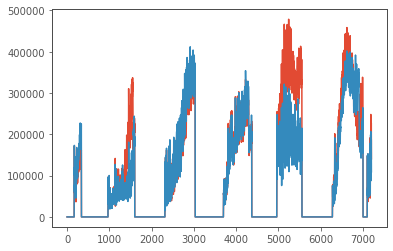

In [46]:
plt.plot(diffPred1.sum(axis=0))
plt.plot(diffPred2.sum(axis=0))

In [43]:
diffPred2.sum(axis=0)

array([     0.        ,      0.        ,      0.        , ...,
       160469.49619843, 147117.41505559, 109243.89271104])

In [37]:
errH1 < np.array(errsH0)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

### Save results

In [219]:
def obtainwU(DetObj):
    eigVecs = DetObj.midRes.eigVecs[:, :DetObj.paras.r]
    kpidxs = np.concatenate([[0], DetObj.ecpts]).astype(np.int)
    eigVals = DetObj.RecResCur.LamMs[:, kpidxs]
    wU = eigVecs.dot(eigVals)
    return wU

def minmax(x):
    num = x - np.min(x)
    den = np.max(x) - np.min(x)
    return num/den

In [220]:
wUst = obtainwU(detRawNo)
wUst = np.transpose(wUst)
abswUst = np.abs(wUst)
# save to npy file
with open("../results/MEG-eye-wU/MEG02_NonScreening_abswU_full.npy", "wb") as f:
    np.save(f, abswUst)
with open("../results/MEG-eye-wU/MEG02_NonScreening_wU_full.npy", "wb") as f:
    np.save(f, wUst)

abswUstMM = np.zeros_like(abswUst)
for i, col in enumerate(abswUst):
    lh = minmax(col[:34])
    rh = minmax(col[34:])
    abswUstMM[i, :34] = lh
    abswUstMM[i, 34:] = rh

In [119]:
import pandas as pd

fcR = pd.read_csv('../data/brain_plot_meg/DK_dic68.csv').set_index('Unnamed: 0')
rowNames = list(fcR.index)
colNames = np.array(fcR.columns)

fcRarr = np.array(fcR)

# minmax 
fcRarrMM = np.zeros_like(fcRarr)
for i, fcRar in enumerate(fcRarr):
    lh = minmax(fcRar[:34])
    rh = minmax(fcRar[34:])
    fcRarrMM[i, :34] = lh
    fcRarrMM[i, 34:] = rh

In [120]:
from collections import OrderedDict as odict
csvD = odict()
for i, name in enumerate(colNames):
    csvD[name] = abswUstMM[:, i]

csvD = pd.DataFrame(csvD)
csvD.to_csv("../results/MEG-eye-wU/wU_minmax_NonScreening_st02.csv")

In [121]:
import scipy.stats as ss
from collections import defaultdict as ddict
corrs = ddict(list)
for absU in abswUstMM:
    for j, name in enumerate(rowNames):
        corrs[name].append(ss.pearsonr(fcRarrMM[j, :], absU)[0])
        #corrs[name].append(ss.spearmanr(fcRarrMM[j, :], absU)[0])
    
corrsDF = pd.DataFrame(corrs)
corrsDF.to_csv("../results/MEG-eye-wU/corrs_NonScreening_st02.csv")
corrsDF

,Default,Dorsal_Attention,Frontoparietal,Limbic,Somatomotor,Ventral_Attention,Visual
0,0.021523,-0.163579,-0.292984,0.044899,-0.169305,-0.281270,0.491437
1,-0.194136,0.200498,0.061212,-0.216674,0.347668,0.229317,-0.164901
2,0.334726,-0.138628,-0.059043,0.315971,-0.396542,-0.297212,0.085103
3,0.223529,0.039289,0.088009,0.203110,-0.245554,-0.079727,-0.184560
4,0.082151,0.068585,-0.032300,0.086277,0.194600,0.004702,-0.325958
5,0.187684,0.124312,-0.201965,0.120732,-0.246493,-0.173467,0.124911
6,0.091255,-0.101870,-0.132063,0.115589,-0.352254,-0.332151,0.478900


#### corr of wU via second way

In [122]:
def obtainAbswU2(DetObj):
    absEigVecs = np.abs(DetObj.midRes.eigVecs[:, :DetObj.paras.r])
    kpidxs = np.concatenate([[0], DetObj.ecpts]).astype(np.int)
    absEigVals = np.abs(DetObj.RecResCur.LamMs[:, kpidxs])
    wU = absEigVecs.dot(absEigVals)
    return np.abs(wU)

abswUst2 = obtainAbswU2(detRawNo)
abswUst2 = np.transpose(abswUst2)

abswUst2MM = np.zeros_like(abswUst2)
for i, col in enumerate(abswUst2):
    lh = minmax(col[:34])
    rh = minmax(col[34:])
    abswUst2MM[i, :34] = lh
    abswUst2MM[i, 34:] = rh
    
corrs = ddict(list)
for abswU in abswUst2MM:
    for j, name in enumerate(rowNames):
        corrs[name].append(ss.pearsonr(fcRarrMM[j, :], abswU)[0])
    
corrsDF2 = pd.DataFrame(corrs)
corrsDF2

,Default,Dorsal_Attention,Frontoparietal,Limbic,Somatomotor,Ventral_Attention,Visual
0,0.144161,-0.077756,-0.235874,0.319965,-0.310647,-0.377813,0.197538
1,0.287953,-0.145730,-0.197553,0.330083,-0.270594,-0.332406,0.056804
2,0.290524,-0.151157,-0.150654,0.228205,-0.267050,-0.266961,0.089860
3,0.186253,-0.106743,-0.224341,0.307262,-0.336251,-0.374559,0.213226
4,0.273511,-0.135840,-0.202236,0.390571,-0.171078,-0.299346,-0.104216
5,0.281076,-0.141866,-0.204334,0.339720,-0.271891,-0.340148,0.058038
6,0.264289,-0.146349,-0.162592,0.224833,-0.309419,-0.291375,0.161209


#### corr of U 

In [123]:
r = detRawNo.paras.r
rUs = detRawNo.midRes.eigVecs[:, :r]
kpidxs = np.where(np.diff(np.concatenate([[np.Inf], np.abs(rUs[0, :])])) != 0)[0]
Us = rUs[:, kpidxs]
absUs = np.abs(Us).T

absUsMM = np.zeros_like(absUs)
for i, col in enumerate(absUs):
    lh = minmax(col[:34])
    rh = minmax(col[34:])
    absUsMM[i, :34] = lh
    absUsMM[i, 34:] = rh
    
Ucorrs = ddict(list)
for absU in absUsMM:
    for j, name in enumerate(rowNames):
        Ucorrs[name].append(ss.pearsonr(fcRarrMM[j, :], absU)[0])
    
UcorrsDF = pd.DataFrame(Ucorrs)
#UcorrsDF.to_csv("../results/MEG-eye-wU/Ucorrs_NonScreenig_st02.csv")
UcorrsDF

,Default,Dorsal_Attention,Frontoparietal,Limbic,Somatomotor,Ventral_Attention,Visual
0,0.256751,-0.154747,-0.000404,-0.034367,-0.235574,-0.090206,0.183165
1,0.105660,-0.041270,-0.228311,0.282689,-0.311087,-0.382284,0.249015
2,0.261621,-0.129241,-0.142513,0.368667,-0.026842,-0.183876,-0.292283


## Results of other methods

In [22]:
import rpy2.robjects as robj

robj.r.source("../Rcode/utils.R")
RsegCorr = robj.r["segCorr"]
RsegPCA = robj.r["segPCA"]
RsegDMD = robj.r["DMD"]
RchgF = robj.r["chgF"]
RsegDMDOrg = robj.r["DMDOrg"]
RsegPCAOrg = robj.r["segPCAOrg"]

In [23]:
ecptss = edict()
d, n = dataN.shape

oparas = edict()
oparas.rank = 0.7
oparas.slidew = 40
oparas.wsizes = [200, 400, 600, 800, 1000, 1200]


for wsize in oparas.wsizes:
    ecpts = edict()
    
    seqw = np.arange(1, n-wsize, oparas.slidew)
    rSeqw = py2Rvec(seqw)
    rYmat = py2Rmat(dataN)
    
    # Detection results for DCOR
    rDCORres = RsegCorr(rYmat, wsize, rSeqw)
    rDCORecpts = RchgF(rDCORres, rSeqw)
    ecpts.DCOR = np.array(rDCORecpts)
        
    # Detection results for PCA
    rPCAres = RsegPCA(rYmat, wsize, rSeqw, rank=oparas.rank)
    rPCAecpts = RchgF(rPCAres, rSeqw)
    ecpts.PCA = np.array(rPCAecpts)
        
    # Detection results for DMD
    rDMDres = RsegDMD(rYmat, wsize, rSeqw, rank=oparas.rank)
    rDMDecpts = RchgF(rDMDres, rSeqw)
    ecpts.DMD = np.array(rDMDecpts)
    
    ecptss[f'w{wsize}'] = ecpts

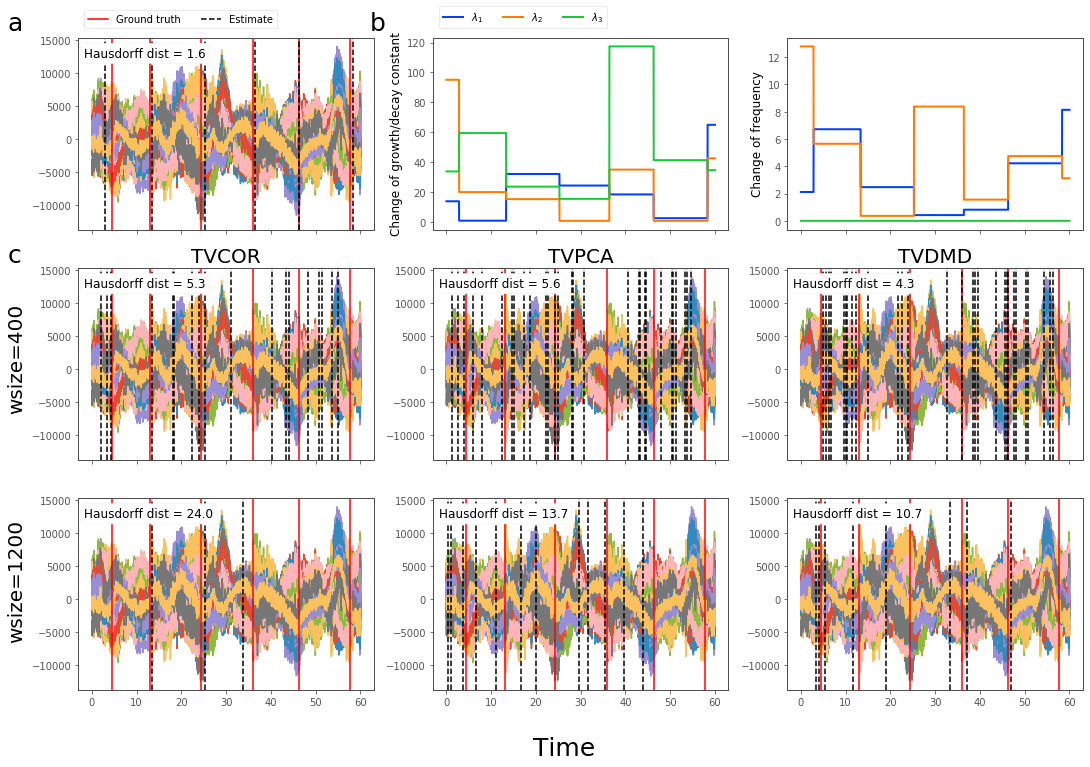

In [128]:
ptime = np.linspace(0, 60, n)
ajfct = n/60
names = ["DCOR", "PCA", "DMD"]
wsizes = [400, 1200]
props = dict(boxstyle='round', facecolor='white', alpha=1)


fig, axs= plt.subplots(nrows=len(wsizes)+1, ncols=3, sharex=True, sharey=False, figsize=(18, 4*(len(wsizes)+1)))

chist = hdist(detRawNo.ecpts/ajfct, gtSt02.ts)
for i in range(d):
    axs[0, 0].plot(detRawNo.ptime, detRawNo.nYmat[i, :], "-")

for j, cpt in enumerate(gtSt02.cpts):
    if j == 0:
        axs[0, 0].axvline(cpt/ajfct, color="red", linestyle="-", label="Ground truth")
    else:
        axs[0, 0].axvline(cpt/ajfct, color="red", linestyle="-")
for j, ecpt in enumerate(detRawNo.ecpts):
    if j == 0:
        axs[0, 0].axvline(ecpt/ajfct, color="black", linestyle="--", label="Estimate")
    else:
        axs[0, 0].axvline(ecpt/ajfct, color="black", linestyle="--")
axs[0, 0].text(0.02, 0.90, f'Hausdorff dist = {np.round(chist, 1)}', transform=axs[0, 0].transAxes, fontsize=12, bbox=props)
        
for i0, i in enumerate(pltIdxs):
    labs = f"$\\lambda_{i0+1}$"
    axs[0, 1].plot(detRawNo.ptime, np.abs(ReLamMs[i, :]), label=labs, 
             color=cols[i0], linewidth=2)
axs[0, 1].set_ylabel("Change of growth/decay constant")
#axs[0, 1].set_ylim([-10, 155])
#axs[0, 1].legend(loc="upper left")

for i0, i in enumerate(pltIdxs):
    labs = f"$\\lambda_{i0+1}$"
    axs[0, 2].plot(detRawNo.ptime, np.abs(ImLamMs[i, :]), label=labs, 
             color=cols[i0], linewidth=2)
axs[0, 2].set_ylabel("Change of frequency")
#axs[0, 2].set_ylim([-1, 20])
#axs[0, 2].legend(loc="upper right")

for fi in range(1, len(wsizes)+1):
    for fj in range(3):
        ecpts = ecptss[f"w{wsizes[fi-1]}"][names[fj]] 
        chist = hdist(ecpts/ajfct, gtSt02.ts)
        for i in range(d):
            axs[fi, fj].plot(ptime, dataN[i, :])
        for cpt in gtSt02.cpts:
            axs[fi, fj].axvline(cpt/ajfct, color="red", linestyle="-")
        for ecpt in ecpts:
            axs[fi, fj].axvline(ecpt/ajfct, color="black", linestyle="--")
        axs[fi, fj].text(0.02, 0.90, f'Hausdorff dist = {np.round(chist, 1)}', transform=axs[fi, fj].transAxes, fontsize=12, bbox=props) 
        
axs[1, 0].set_title("TVCOR", fontsize=20)
axs[1, 1].set_title("TVPCA", fontsize=20)
axs[1, 2].set_title("TVDMD", fontsize=20)


handles, labels = axs[0, 0].get_legend_handles_labels()
axs[0, 0].legend(handles, labels, loc=(0.02, 1.05), ncol=2)
handles, labels = axs[0, 1].get_legend_handles_labels()
axs[0, 1].legend(handles, labels, loc=(0.02, 1.05), ncol=3)

fig.text(0.5, 0.05, 'Time', ha='center', fontsize=25)
fig.text(0.07, 8/9, "a",  fontsize=25)
fig.text(0.35, 8/9, "b",  fontsize=25)
fig.text(0.07, 0.62, "c",  fontsize=25)

for i in range(len(wsizes)):
    fig.text(0.07, 0.185+i*0.265, f"wsize={wsizes[::-1][i]}", rotation="vertical", fontsize=20)
    
plt.savefig("../plots/MEG-EYE-02-res-combo.jpg", bbox_inches='tight')

In [129]:
plt.figure(figsize=[6, 4])

for wsize in wsizes[:]:
    for i in range(d):
        plt.plot(ptime, dataN[i, :])
    for ii, cpt in enumerate(gtSt02.cpts):
        if ii == 0:
            plt.axvline(cpt/ajfct, color="red", linestyle="-", label="Ground truth")
        else:
            plt.axvline(cpt/ajfct, color="red", linestyle="-")
    ecpts = ecptss[f"w{wsize}"]["DCOR"]
    chist = hdist(ecpts/ajfct, gtSt02.ts)
    ax = plt.gca()
    ax.text(0.60, 0.90, f'Hausdorff dist = {np.round(chist, 1)}', transform=ax.transAxes, fontsize=12, bbox=props)
    for jj, ecpt in enumerate(ecpts):
        if jj == 0:
            plt.axvline(ecpt/ajfct, color="black", linestyle="--", label="Estimate")
        else:
            plt.axvline(ecpt/ajfct, color="black", linestyle="--")
    plt.legend(loc="upper left")
    plt.savefig(f"../plots/MEG-EYE-02-TVCOR-w{wsize}-ecpts.jpg", bbox_inches='tight')
    plt.close()

In [130]:
plt.figure(figsize=[6, 4])

for wsize in wsizes[:]:
    for i in range(d):
        plt.plot(ptime, dataN[i, :])
    for ii, cpt in enumerate(gtSt02.cpts):
        if ii == 0:
            plt.axvline(cpt/ajfct, color="red", linestyle="-", label="Ground truth")
        else:
            plt.axvline(cpt/ajfct, color="red", linestyle="-")
    ecpts = ecptss[f"w{wsize}"]["DMD"]
    chist = hdist(ecpts/ajfct, gtSt02.ts)
    ax = plt.gca()
    ax.text(0.60, 0.90, f'Hausdorff dist = {np.round(chist, 1)}', transform=ax.transAxes, fontsize=12, bbox=props)
    for jj, ecpt in enumerate(ecpts):
        if jj == 0:
            plt.axvline(ecpt/ajfct, color="black", linestyle="--", label="Estimate")
        else:
            plt.axvline(ecpt/ajfct, color="black", linestyle="--")
    plt.legend(loc="upper left")
    plt.savefig(f"../plots/MEG-EYE-02-TVDMD-w{wsize}-ecpts.jpg", bbox_inches='tight')
    plt.close()

In [131]:
plt.figure(figsize=[6, 4])

for wsize in wsizes[:]:
    for i in range(d):
        plt.plot(ptime, dataN[i, :])
    for ii, cpt in enumerate(gtSt02.cpts):
        if ii == 0:
            plt.axvline(cpt/ajfct, color="red", linestyle="-", label="Ground truth")
        else:
            plt.axvline(cpt/ajfct, color="red", linestyle="-")
    ecpts = ecptss[f"w{wsize}"]["PCA"]
    chist = hdist(ecpts/ajfct, gtSt02.ts)
    ax = plt.gca()
    ax.text(0.60, 0.90, f'Hausdorff dist = {np.round(chist, 1)}', transform=ax.transAxes, fontsize=12, bbox=props)
    for jj, ecpt in enumerate(ecpts):
        if jj == 0:
            plt.axvline(ecpt/ajfct, color="black", linestyle="--", label="Estimate")
        else:
            plt.axvline(ecpt/ajfct, color="black", linestyle="--")
    plt.legend(loc="upper left")
    plt.savefig(f"../plots/MEG-EYE-02-TVPCA-w{wsize}-ecpts.jpg", bbox_inches='tight')
    plt.close()

## Analysis on alpha-MEG

In [221]:
newDataDir = Path("../data/MEG-eye-multiFreqs")
newDatFil = list(newDataDir.glob("*02*alpha*min.mat"))[0]
print(newDatFil)
gtF = list(dataDir.glob("*02_st.txt"))[0]
gtSt02 = time2pts(txt2Time(gtF), timeLims.st02)

../data/MEG-eye-multiFreqs/lcmv_DKregion_R2868E_02-st_alpha_min.mat


In [222]:
newMEG = loadmat(newDatFil)
nData = newMEG["DK_timecourse"]
q = 10
nDataN = decimate(nData, q=q)
nDataN = detrend(nDataN)

In [223]:
n = nDataN.shape[1]
ecpts = detRawNo.ecpts
ecptsFull = np.concatenate([[0], ecpts, [n]])
ecptsFull = ecptsFull.astype(np.int)

In [224]:
paras = edict()
paras.Lmin = 200
paras.wh = 10
paras.MaxM = 20
paras.fct = 0.5
paras.r = 0.7
paras.freq = 120
paras.lamb = 1e-4
paras.T = 2
paras.is_detrend = False
paras.decimateRate = None
paras.kappa = 1
paras.downRate = 20

In [225]:
detRawAlp = TVDNDetect1(Ymat=nDataN, dataType="MEG", 
                     saveDir=None, 
                     fName="MEG1",
                     showProgress=True, 
                     MaxM=paras.MaxM,
                     Lmin=paras.Lmin, 
                     lamb=paras.lamb, 
                     kappa=paras.kappa, 
                     freq=paras.freq,
                     r=paras.r,
                     T=paras.T,
                     is_detrend=paras.is_detrend,
                     decimateRate=paras.decimateRate, 
                     downRate=paras.downRate)

The parameters for detection are:
{'Lmin': 200,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 20,
 'fName': 'MEG1',
 'fct': 0.5,
 'freq': 120,
 'is_detrend': False,
 'kappa': 1,
 'lamb': 0.0001,
 'nbasis': 10,
 'r': 0.7}


In [226]:
detRawAlp.GetNewData()
detRawAlp.ecpts = detRawNo.ecpts
detRawAlp.finalRes = 1

In [227]:
midRes = detRawAlp.midRes
_, n = midRes.nXmat.shape
r = detRawAlp.paras.r
time = np.linspace(0, detRawAlp.paras.T, n)
tStep = np.diff(time)[0]
ndXmat = midRes.ndXmat
nXmat = midRes.nXmat
kpidxs = midRes.kpidxs
eigVecs = midRes.eigVecs
detRawAlp.RecResCur = ReconXmat(detRawAlp.ecpts, ndXmat, nXmat, kpidxs, eigVecs, detRawAlp.nYmat, tStep, r=r, is_full=True)

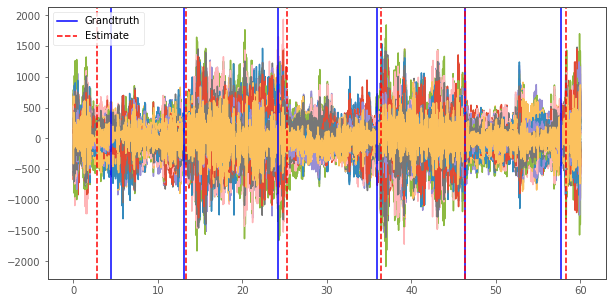

In [156]:
detRawAlp.PlotEcpts(GT=gtSt02.cpts)

### Save results for alpha-MEG

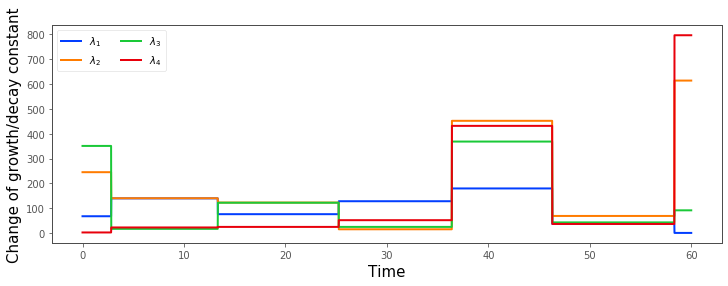

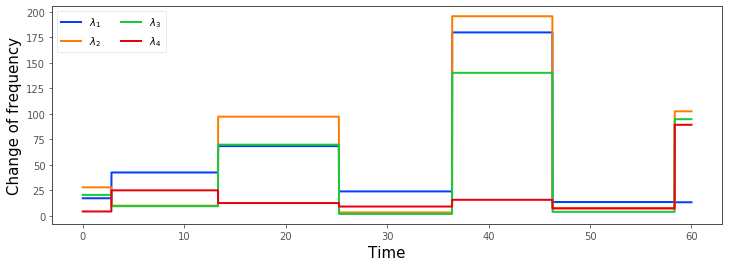

In [228]:
freq = detRawAlp.paras.freq
numChgCur = len(detRawAlp.ecpts)
LamMs = detRawAlp.RecResCur.LamMs
rAct, n = LamMs.shape
pltIdxs = np.arange(1, rAct)[np.diff(np.abs(LamMs), axis=0).astype(np.bool).all(axis=1)] 
pltIdxs = np.concatenate([[0], pltIdxs])
acTime = n / detRawAlp.paras.freq
ReLamMs = freq*LamMs.real/(acTime/detRawAlp.paras.T)
ImLamMs = freq*LamMs.imag/((2*np.pi)*(acTime/detRawAlp.paras.T))
cols = sns.color_palette("bright", len(pltIdxs))

plt.figure(figsize=[12,4])
for i0, i in enumerate(pltIdxs):
    labs = f"$\\lambda_{i0+1}$"
    plt.plot(detRawAlp.ptime, np.abs(ReLamMs[i, :]), label=labs, 
             color=cols[i0], linewidth=2)
plt.ylabel("Change of growth/decay constant", fontsize=15)
plt.xlabel("Time", fontsize=15)
#plt.ylim([-10, 130])
_ = plt.legend(loc="upper left", ncol=2)
plt.savefig("../plots/MEG-EYE-02-eigReal-alp.jpg", bbox_inches='tight')
plt.show()

plt.figure(figsize=[12,4])
for i0, i in enumerate(pltIdxs):
    labs = f"$\\lambda_{i0+1}$"
    plt.plot(detRawAlp.ptime, np.abs(ImLamMs[i, :]), label=labs, 
             color=cols[i0], linewidth=2)
plt.ylabel("Change of frequency", fontsize=15)
#plt.ylim([-1,38])
plt.xlabel("Time", fontsize=15)
_ = plt.legend(loc="upper left", ncol=2)
plt.savefig("../plots/MEG-EYE-02-eigImag-alp.jpg", bbox_inches='tight')
plt.show() 

In [229]:
def obtainwU(DetObj):
    eigVecs = DetObj.midRes.eigVecs[:, :DetObj.paras.r]
    kpidxs = np.concatenate([[0], DetObj.ecpts]).astype(np.int)
    eigVals = DetObj.RecResCur.LamMs[:, kpidxs]
    wU = eigVecs.dot(eigVals)
    return wU

def minmax(x):
    num = x - np.min(x)
    den = np.max(x) - np.min(x)
    return num/den

In [230]:
wUst = obtainwU(detRawAlp)
wUst = np.transpose(wUst)
abswUst = np.abs(wUst)
# save to npy file
with open("../results/MEG-eye-wU/MEG02_NonScreening_abswU_full_alp.npy", "wb") as f:
    np.save(f, abswUst)
with open("../results/MEG-eye-wU/MEG02_NonScreening_wU_full_alp.npy", "wb") as f:
    np.save(f, wUst)

abswUstMM = np.zeros_like(abswUst)
for i, col in enumerate(abswUst):
    lh = minmax(col[:34])
    rh = minmax(col[34:])
    abswUstMM[i, :34] = lh
    abswUstMM[i, 34:] = rh

In [231]:
import pandas as pd

fcR = pd.read_csv('../data/brain_plot_meg/DK_dic68.csv').set_index('Unnamed: 0')
rowNames = list(fcR.index)
colNames = np.array(fcR.columns)

fcRarr = np.array(fcR)

# minmax 
fcRarrMM = np.zeros_like(fcRarr)
for i, fcRar in enumerate(fcRarr):
    lh = minmax(fcRar[:34])
    rh = minmax(fcRar[34:])
    fcRarrMM[i, :34] = lh
    fcRarrMM[i, 34:] = rh

In [232]:
from collections import OrderedDict as odict
csvD = odict()
for i, name in enumerate(colNames):
    csvD[name] = abswUstMM[:, i]

csvD = pd.DataFrame(csvD)
csvD.to_csv("../results/MEG-eye-wU/wU_minmax_NonScreening_st02_alp.csv")

In [233]:
import scipy.stats as ss
from collections import defaultdict as ddict
corrs = ddict(list)
for absU in abswUstMM:
    for j, name in enumerate(rowNames):
        corrs[name].append(ss.pearsonr(fcRarrMM[j, :], absU)[0])
        #corrs[name].append(ss.spearmanr(fcRarrMM[j, :], absU)[0])
    
corrsDF = pd.DataFrame(corrs)
corrsDF.to_csv("../results/MEG-eye-wU/corrs_NonScreening_st02_alp.csv")
corrsDF

,Default,Dorsal_Attention,Frontoparietal,Limbic,Somatomotor,Ventral_Attention,Visual
0,0.107260,-0.070054,0.009200,-0.030615,0.069963,0.147689,-0.175067
1,0.066195,0.173804,-0.015258,0.001031,0.176014,-0.052110,-0.207525
2,-0.010387,-0.069487,-0.124194,-0.080344,-0.141874,-0.185135,0.441457
3,-0.145702,0.466901,0.011530,-0.422342,0.309866,0.236802,-0.109091
4,-0.199142,0.227352,-0.151702,-0.162859,0.023562,-0.090820,0.329244
5,-0.124954,0.138076,-0.123086,0.102226,-0.206260,-0.077927,0.234662
6,-0.175147,0.047288,-0.201945,0.048106,-0.108037,-0.032038,0.285186


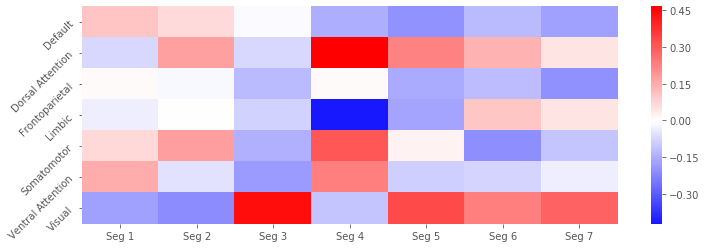

In [234]:
xticklabel = ['Default', 'Dorsal Attention', 'Frontoparietal', 'Limbic', 'Somatomotor', 'Ventral Attention', 'Visual']
corrsArr = np.array(corrsDF)
plt.figure(figsize=[12, 4])
sns.heatmap(corrsArr.T, cbar=1, square=False, center=0, 
                    cmap="bwr")
plt.yticks(0.5+np.arange(0, 7, 1), xticklabel, rotation=45)
plt.xticks(0.5+np.arange(0, 7, 1), ["Seg " + str(i) for i in range(1, 8)], rotation=0)
plt.savefig("../plots/MEG-EYE-02-alp-wUcorr-heatmap.jpg", bbox_inches='tight')

#### corr of wU via second way

In [169]:
def obtainAbswU2(DetObj):
    absEigVecs = np.abs(DetObj.midRes.eigVecs[:, :DetObj.paras.r])
    kpidxs = np.concatenate([[0], DetObj.ecpts]).astype(np.int)
    absEigVals = np.abs(DetObj.RecResCur.LamMs[:, kpidxs])
    wU = absEigVecs.dot(absEigVals)
    return np.abs(wU)

abswUst2 = obtainAbswU2(detRawAlp)
abswUst2 = np.transpose(abswUst2)

abswUst2MM = np.zeros_like(abswUst2)
for i, col in enumerate(abswUst2):
    lh = minmax(col[:34])
    rh = minmax(col[34:])
    abswUst2MM[i, :34] = lh
    abswUst2MM[i, 34:] = rh
    
corrs = ddict(list)
for abswU in abswUst2MM:
    for j, name in enumerate(rowNames):
        corrs[name].append(ss.pearsonr(fcRarrMM[j, :], abswU)[0])
    
corrsDF2 = pd.DataFrame(corrs)
corrsDF2

,Default,Dorsal_Attention,Frontoparietal,Limbic,Somatomotor,Ventral_Attention,Visual
0,-0.139915,0.011017,-0.169613,-0.195669,0.212229,0.139334,0.111583
1,-0.192241,0.094919,-0.195223,-0.210226,0.205141,0.155198,0.127670
2,-0.164342,0.035646,-0.182202,-0.203259,0.229235,0.153678,0.098926
3,-0.162234,0.152164,-0.176111,-0.182537,0.197520,0.145276,0.061008
4,-0.179393,0.042755,-0.191320,-0.211518,0.219992,0.155814,0.125821
5,-0.201120,0.050970,-0.200541,-0.215164,0.201406,0.156550,0.160281
6,-0.217182,-0.056495,-0.194825,-0.197731,0.093585,0.116176,0.327798


#### corr of U 

In [170]:
r = detRawAlp.paras.r
rUs = detRawAlp.midRes.eigVecs[:, :r]
kpidxs = np.where(np.diff(np.concatenate([[np.Inf], np.abs(rUs[0, :])])) != 0)[0]
Us = rUs[:, kpidxs]
absUs = np.abs(Us).T

absUsMM = np.zeros_like(absUs)
for i, col in enumerate(absUs):
    lh = minmax(col[:34])
    rh = minmax(col[34:])
    absUsMM[i, :34] = lh
    absUsMM[i, 34:] = rh
    
Ucorrs = ddict(list)
for absU in absUsMM:
    for j, name in enumerate(rowNames):
        Ucorrs[name].append(ss.pearsonr(fcRarrMM[j, :], absU)[0])
    
UcorrsDF = pd.DataFrame(Ucorrs)
#UcorrsDF.to_csv("../results/MEG-eye-wU/Ucorrs_NonScreenig_st02-alp.csv")
UcorrsDF

,Default,Dorsal_Attention,Frontoparietal,Limbic,Somatomotor,Ventral_Attention,Visual
0,-0.095675,0.213319,-0.136140,-0.146363,0.249049,0.134705,-0.104844
1,-0.079711,-0.041740,-0.117817,-0.110514,0.178073,0.092119,0.055192
2,-0.112854,-0.001837,-0.140108,-0.184278,0.174810,0.118061,0.119452
3,-0.253995,-0.031587,-0.114017,-0.016000,-0.174467,0.054645,0.344398


### Exp Dist Mat of segments

In [238]:
from scipy.spatial.distance import pdist, squareform

In [239]:
def stdAndNorm(segMat):
    nrow = segMat.shape[0]
    stdMat = []
    normMat = []
    for i in range(nrow):
        curRow = segMat[i, :]
        stdRow = (curRow - np.mean(curRow))/np.std(curRow)
        normRow = (curRow - np.min(curRow))/(np.max(curRow)-np.min(curRow))
        stdMat.append(stdRow)
        normMat.append(normRow)
        
    stdMat = np.array(stdMat)
    normMat = np.array(normMat)
    return {"std":stdMat, "norm":normMat} 

In [240]:
ecpts = detRawAlp.ecpts
ecptsFull = np.concatenate([[0], ecpts, [nDataN.shape[1]]])
ecptsFull = ecptsFull.astype(np.int)

In [241]:
stdExpDMats = []
normExpDMats = []
expDMats = []
for i in range(len(ecptsFull)-1):
    lidx, uidx = ecptsFull[i], ecptsFull[i+1]
    segMat = nDataN[:, lidx:uidx]
    stdNormMat = stdAndNorm(segMat)
    
    stdExpDMat = np.exp(-squareform(pdist((stdNormMat["std"])))/np.std(pdist((stdNormMat["std"]))))
    normExpDMat = np.exp(-squareform(pdist((stdNormMat["norm"])))/np.std(pdist((stdNormMat["norm"]))))
    expDMat = np.exp(-squareform(pdist((segMat)))/np.std(pdist((segMat))))
    
    #thre = np.median(normExpDMat)
    
    #expDMat[np.abs(expDMat) > thre] = 1
    #normExpDMat[np.abs(normExpDMat) > thre] = 1
    #stdExpDMat[np.abs(stdExpDMat) > thre] = 1
    #
    #expDMat[np.abs(expDMat) < thre] = 0
    #normExpDMat[np.abs(normExpDMat) < thre] = 0
    #stdExpDMat[np.abs(stdExpDMat) < thre] = 0
    
    expDMats.append(expDMat)
    stdExpDMats.append(stdExpDMat)
    normExpDMats.append(normExpDMat)

/home/huaqingj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  app.launch_new_instance()


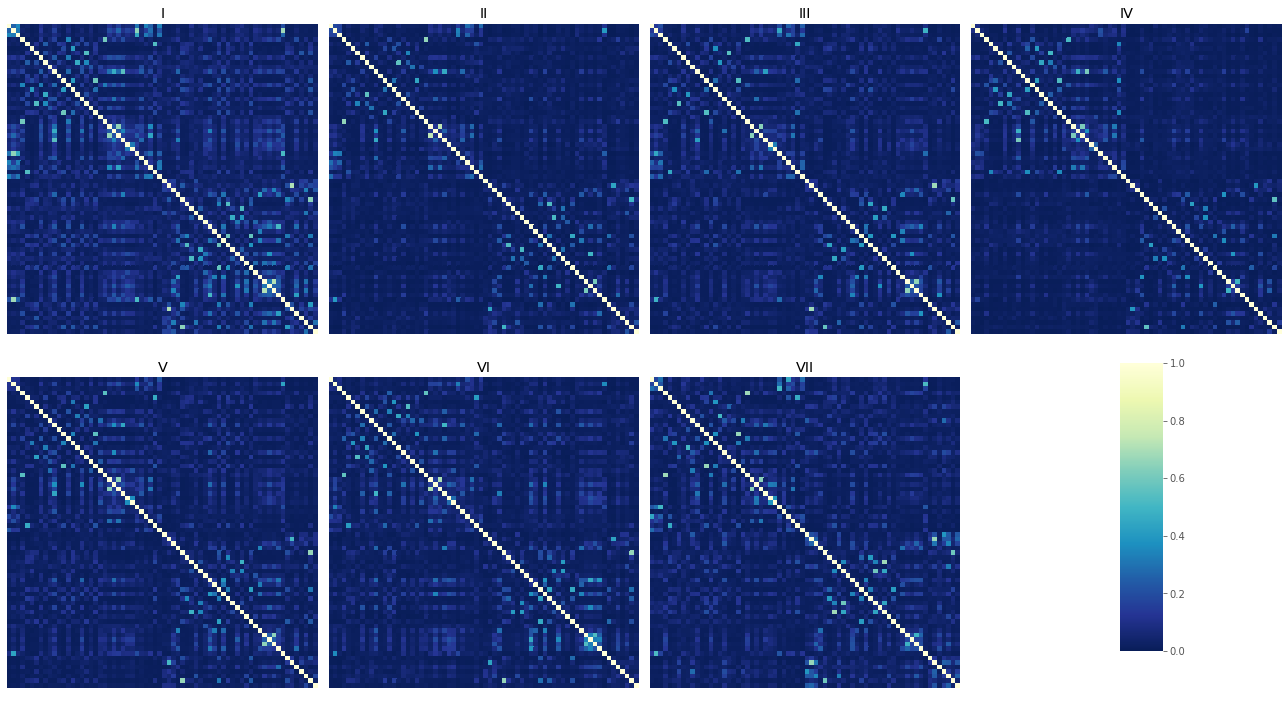

In [242]:
romNums = ["I", "II", "III", "IV", "V", "VI", "VII", "VIII", "IX"]
fig, axs = plt.subplots(2, 4, figsize=[20, 10])
# cbar_ax = fig.add_axes([.91, .3, .03, .4])
cbar_ax = fig.add_axes([.78, .08, .03, .4])
for i in range(2):
    for j in range(4):
        idx = i*4 + j
        if idx == 7:
            axs[i, j].axis("off")
            break
        sns.heatmap(normExpDMats[idx], vmin=0, vmax=1, cbar=idx==0, square=True, 
                    cmap="YlGnBu_r", ax=axs[i, j], cbar_ax=None if idx else cbar_ax)
        axs[i, j].set_title(romNums[idx])
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
fig.tight_layout(rect=[0, 0, .9, 1])
plt.savefig("../plots/MEG-EYE-02-alp-ExpDist-heatmap.jpg", bbox_inches='tight')

### Heatmap for orginal dataset

In [243]:
stdExpDMats = []
normExpDMats = []
expDMats = []
for i in range(len(ecptsFull)-1):
    lidx, uidx = ecptsFull[i], ecptsFull[i+1]
    segMat = dataN[:, lidx:uidx]
    stdNormMat = stdAndNorm(segMat)
    
    stdExpDMat = np.exp(-squareform(pdist((stdNormMat["std"])))/np.std(pdist((stdNormMat["std"]))))
    normExpDMat = np.exp(-squareform(pdist((stdNormMat["norm"])))/np.std(pdist((stdNormMat["norm"]))))
    expDMat = np.exp(-squareform(pdist((segMat)))/np.std(pdist((segMat))))
    
    #thre = np.median(normExpDMat)
    
    #expDMat[np.abs(expDMat) > thre] = 1
    #normExpDMat[np.abs(normExpDMat) > thre] = 1
    #stdExpDMat[np.abs(stdExpDMat) > thre] = 1
    #
    #expDMat[np.abs(expDMat) < thre] = 0
    #normExpDMat[np.abs(normExpDMat) < thre] = 0
    #stdExpDMat[np.abs(stdExpDMat) < thre] = 0
    
    expDMats.append(expDMat)
    stdExpDMats.append(stdExpDMat)
    normExpDMats.append(normExpDMat)

/home/huaqingj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  from ipykernel import kernelapp as app


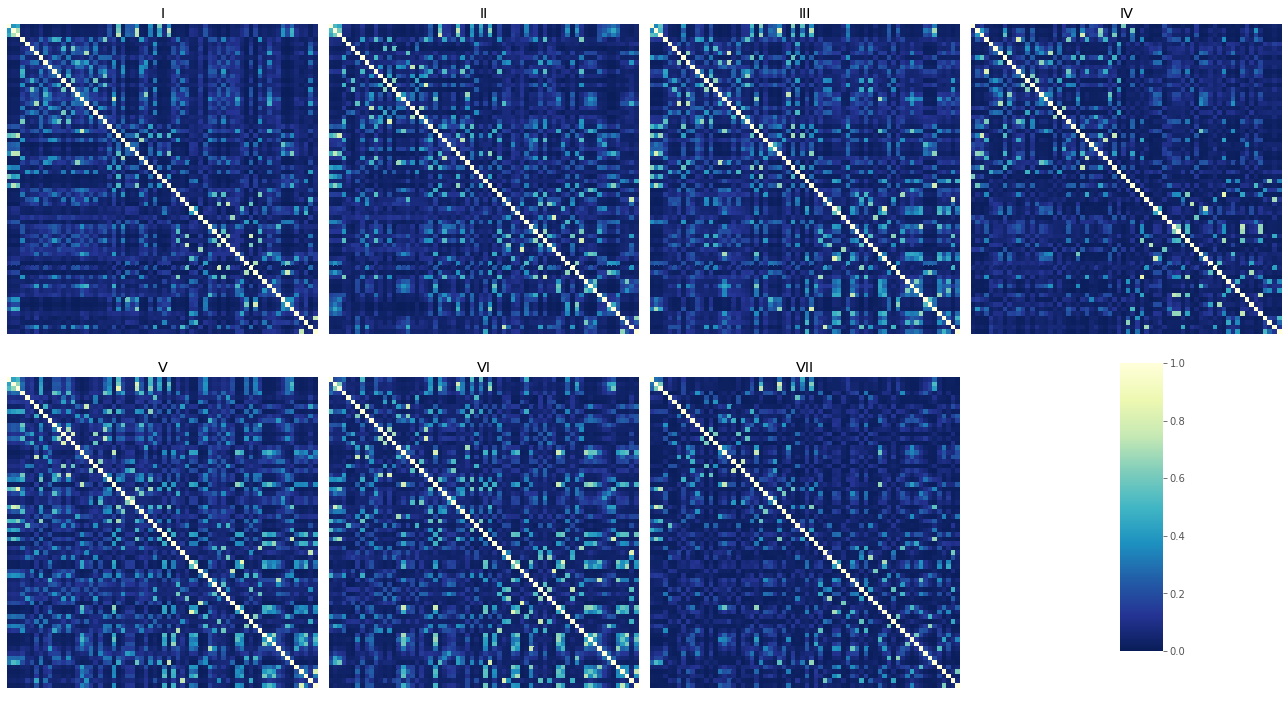

In [244]:
fig, axs = plt.subplots(2, 4, figsize=[20, 10])
# cbar_ax = fig.add_axes([.91, .3, .03, .4])
cbar_ax = fig.add_axes([.78, .08, .03, .4])
for i in range(2):
    for j in range(4):
        idx = i*4 + j
        if idx == 7:
            axs[i, j].axis("off")
            break
        sns.heatmap(normExpDMats[idx], vmin=0, vmax=1, cbar=idx==0, square=True, 
                    cmap="YlGnBu_r", ax=axs[i, j], cbar_ax=None if idx else cbar_ax)
        axs[i, j].set_title(romNums[idx])
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
fig.tight_layout(rect=[0, 0, .9, 1])
plt.savefig("../plots/MEG-EYE-02-ExpDist-heatmap.jpg", bbox_inches='tight')